Домашее задание номер 2. Взять произвольную аудиозапись. Получить ее мел спектрограмму (используя вашу реализацию!). Прогнать любой алгоритм шумоподавления (или написать свой!). И получить мелспектрограмму полученного сигнала. Посчитать метрики до и после.

In [86]:
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
import librosa
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [87]:
def hz_to_mel(f_hz):
    f_hz = np.asarray(f_hz, dtype=float)
    return 2595.0 * np.log10(1.0 + f_hz / 700.0)


def mel_to_hz(m):
    m = np.asarray(m, dtype=float)
    return 700.0 * (10.0 ** (m / 2595.0) - 1.0)


def create_mel_filterbank(
    sr: int,
    n_fft: int,
    n_mels: int = 80,
    fmin: float = 0.0,
    fmax: float | None = None,
    use_slaney_norm: bool = True,
):
    if fmax is None:
        fmax = sr / 2.0

    m_min = hz_to_mel(fmin)
    m_max = hz_to_mel(fmax)
    m_points = np.linspace(m_min, m_max, n_mels + 2)
    f_points = mel_to_hz(m_points)

    fft_freqs = np.linspace(0, sr / 2.0, n_fft // 2 + 1)
    bin_indices = np.searchsorted(fft_freqs, f_points).astype(int)
    bin_indices = np.clip(bin_indices, 0, n_fft // 2)

    H = np.zeros((n_mels, n_fft // 2 + 1), dtype=float)

    for i in range(1, n_mels + 1):
        left = bin_indices[i - 1]
        center = bin_indices[i]
        right = bin_indices[i + 1]

        if center == left:
            center = left + 1
        if right == center:
            right = center + 1

        up = np.linspace(0.0, 1.0, center - left + 1, endpoint=True)
        H[i - 1, left:center + 1] += up

        down = np.linspace(1.0, 0.0, right - center + 1, endpoint=True)[1:]
        H[i - 1, center + 1:right + 1] += down

    if use_slaney_norm:
        enorm = 2.0 / (f_points[2:n_mels + 2] - f_points[:n_mels])
        H *= enorm[:, np.newaxis]

    return H


In [88]:
def mel_spectrogram(
    x: np.ndarray,
    sr: int,
    win_length_ms: float = 25.0,
    hop_length_ms: float = 10.0,
    n_fft: int = 1024,
    n_mels: int = 80,
    fmin: float = 0.0,
    fmax: float | None = None,
    pre_emphasis: float | None = None,
    eps: float = 1e-10,
):
    x = np.asarray(x, dtype=np.float64)

    if x.ndim > 1:
        x = x.mean(axis=1)

    if pre_emphasis is not None and pre_emphasis != 0.0:
        y = np.empty_like(x)
        y[0] = x[0]
        y[1:] = x[1:] - pre_emphasis * x[:-1]
    else:
        y = x

    win_length = int(round(sr * win_length_ms / 1000.0))
    hop_length = int(round(sr * hop_length_ms / 1000.0))

    window = np.hanning(win_length)

    n_samples = len(y)
    if n_samples < win_length:
        pad_width = win_length - n_samples
    else:
        rest = (n_samples - win_length) % hop_length
        pad_width = 0 if rest == 0 else hop_length - rest

    if pad_width > 0:
        y = np.pad(y, (0, pad_width), mode="constant")
        n_samples = len(y)

    n_frames = 1 + (n_samples - win_length) // hop_length

    n_freqs = n_fft // 2 + 1
    P = np.empty((n_freqs, n_frames), dtype=np.float64)

    for i in range(n_frames):
        start = i * hop_length
        frame = y[start:start + win_length]
        frame_win = frame * window
        spectrum = np.fft.rfft(frame_win, n=n_fft)
        power = np.abs(spectrum) ** 2
        P[:, i] = power

    H = create_mel_filterbank(
        sr=sr,
        n_fft=n_fft,
        n_mels=n_mels,
        fmin=fmin,
        fmax=fmax if fmax is not None else sr / 2.0,
        use_slaney_norm=True,
    )

    S_mel = H @ P
    S_log = np.log(S_mel + eps)

    return S_log


In [89]:
audio_path = "acoustic-guitar.wav"

x, sr = sf.read(audio_path)
print(f"Файл: {audio_path}, sr = {sr}, shape = {x.shape}")

if x.ndim > 1:
    x = x.mean(axis=1)

print("Моно shape:", x.shape)


Файл: acoustic-guitar.wav, sr = 44100, shape = (466560, 2)
Моно shape: (466560,)


In [90]:
def add_noise_snr(x: np.ndarray, snr_db: float, seed: int = 0):
    rng = np.random.default_rng(seed)
    x = np.asarray(x, dtype=np.float64)

    sig_power = np.mean(x**2)
    noise_power = sig_power / (10**(snr_db / 10.0))

    noise = rng.normal(scale=np.sqrt(noise_power), size=x.shape)
    x_noisy = x + noise
    return x_noisy, noise


snr_in_db = 5.0
x_clean = x
x_noisy, noise = add_noise_snr(x_clean, snr_in_db)

print("Длины:", len(x_clean), len(x_noisy), len(noise))


Длины: 466560 466560 466560


In [91]:
win_length_ms = 25.0
hop_length_ms = 10.0
n_fft = 2048

win_length = int(round(sr * win_length_ms / 1000.0))
hop_length = int(round(sr * hop_length_ms / 1000.0))
window = "hann"

print("win_length =", win_length, "samples")
print("hop_length =", hop_length, "samples")


win_length = 1102 samples
hop_length = 441 samples


In [92]:
S_clean = librosa.stft(
    x_clean,
    n_fft=n_fft,
    hop_length=hop_length,
    win_length=win_length,
    window="hann",
    center=True,
)

S_noise = librosa.stft(
    noise,
    n_fft=n_fft,
    hop_length=hop_length,
    win_length=win_length,
    window="hann",
    center=True,
)

S_noisy = librosa.stft(
    x_noisy,
    n_fft=n_fft,
    hop_length=hop_length,
    win_length=win_length,
    window="hann",
    center=True,
)

print("STFT shape:", S_clean.shape)


STFT shape: (1025, 1058)


In [93]:
eps = 1e-10

P_clean = np.abs(S_clean) ** 2
P_noise = np.abs(S_noise) ** 2

M = P_clean / (P_clean + P_noise + eps)

M = np.clip(M, 0.0, 1.0)

S_denoised = M * S_noisy


x_denoised = librosa.istft(
    S_denoised,
    hop_length=hop_length,
    win_length=win_length,
    window=window,
    center=False,
)

min_len = min(len(x_clean), len(x_denoised))
x_clean = x_clean[:min_len]
x_noisy = x_noisy[:min_len]
x_denoised = x_denoised[:min_len]

print("Длины после iSTFT:", len(x_clean), len(x_noisy), len(x_denoised))

Длины после iSTFT: 466560 466560 466560


In [94]:
n_mels = 80
fmin = 20.0
fmax = min(8000, sr / 2)

mel_clean = mel_spectrogram(
    x_clean,
    sr,
    win_length_ms=win_length_ms,
    hop_length_ms=hop_length_ms,
    n_fft=n_fft,
    n_mels=n_mels,
    fmin=fmin,
    fmax=fmax,
    pre_emphasis=0.97,
)

mel_noisy = mel_spectrogram(
    x_noisy,
    sr,
    win_length_ms=win_length_ms,
    hop_length_ms=hop_length_ms,
    n_fft=n_fft,
    n_mels=n_mels,
    fmin=fmin,
    fmax=fmax,
    pre_emphasis=0.97,
)

mel_denoised = mel_spectrogram(
    x_denoised,
    sr,
    win_length_ms=win_length_ms,
    hop_length_ms=hop_length_ms,
    n_fft=n_fft,
    n_mels=n_mels,
    fmin=fmin,
    fmax=fmax,
    pre_emphasis=0.97,
)

mel_clean.shape, mel_noisy.shape, mel_denoised.shape


((80, 1057), (80, 1057), (80, 1057))

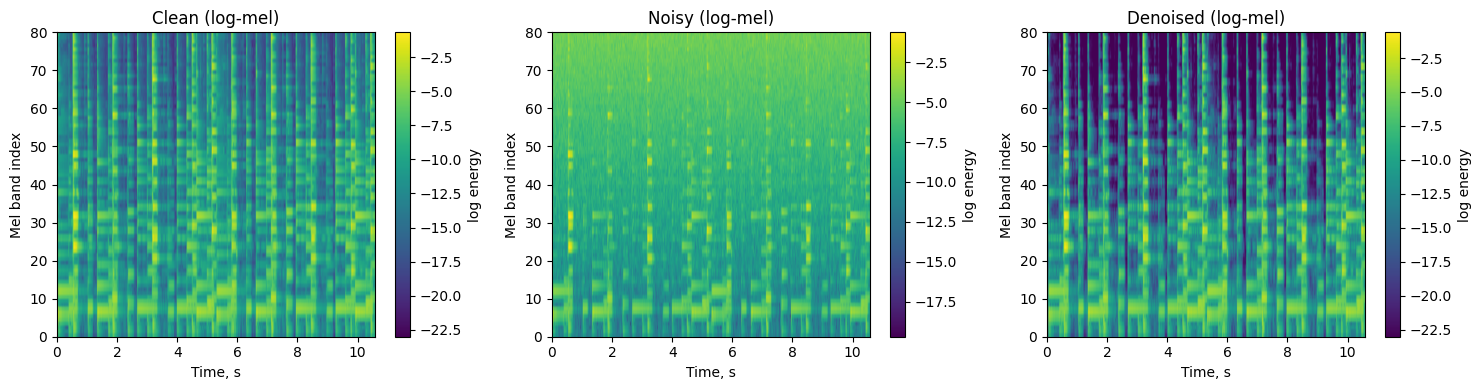

In [95]:
def plot_mel(mel, sr, hop_length, title):
    n_mels, n_frames = mel.shape
    duration_sec = n_frames * hop_length / sr

    plt.imshow(
        mel,
        origin="lower",
        aspect="auto",
        extent=[0, duration_sec, 0, n_mels],
    )
    plt.xlabel("Time, s")
    plt.ylabel("Mel band index")
    plt.title(title)
    plt.colorbar(label="log energy")


plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plot_mel(mel_clean, sr, hop_length, "Clean (log-mel)")

plt.subplot(1, 3, 2)
plot_mel(mel_noisy, sr, hop_length, "Noisy (log-mel)")

plt.subplot(1, 3, 3)
plot_mel(mel_denoised, sr, hop_length, "Denoised (log-mel)")

plt.tight_layout()
plt.show()


In [96]:
def snr_db(ref: np.ndarray, est: np.ndarray, eps: float = 1e-12) -> float:
    ref = np.asarray(ref, dtype=np.float64)
    est = np.asarray(est, dtype=np.float64)

    noise = est - ref
    p_sig = np.sum(ref**2)
    p_noise = np.sum(noise**2) + eps
    return 10.0 * np.log10(p_sig / p_noise)

print("=== SNR ===")
print("Noisy vs clean:    ", snr_db(x_clean, x_noisy))
print("Denoised vs clean: ", snr_db(x_clean, x_denoised))


=== SNR ===
Noisy vs clean:     4.990661839384808
Denoised vs clean:  -3.13788973436374
